In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import datetime
from datetime import datetime
from scipy.stats import pearsonr
# %load_ext rpy2.ipython

In [7]:
df_raw = pd.read_csv("compas-python-master/compas-scores-two-years.csv")
# df_raw.head(5)
# print('Num rows: %d' %len(df_raw))
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

Not all rows are necessary/beneficial for first round of analysis.
Some of the preliminary preprocessing has been borrowed from ProPublica's initial steps in order to keep my analysis consistent.

Some reasons for row removal:
- Missing data
- If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
- Inserted the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
- Ordinary offenses have been removed (e.g. traffic offenses)
- Rows with no score (N/A) have been removed

In [8]:
df_clean = df_raw[((df_raw['days_b_screening_arrest'] <=30) & 
      (df_raw['days_b_screening_arrest'] >= -30) &
      (df_raw['is_recid'] != -1) &
      (df_raw['c_charge_degree'] != 'O') & 
      (df_raw['score_text'] != 'N/A')
     )]
print('Num rows: %d' %len(df_clean))
df_clean.head(5)

Num rows: 6172


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
5,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,...,1,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0
6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1


Higher COMPAS scores have a slight correlation with a longer length of stay

In [9]:
def date_from_str(s):
    return datetime.strptime(s, '%Y-%m-%d %H:%M:%S')

In [10]:
df_clean['length_of_stay'] = (df_clean['c_jail_out'].apply(date_from_str) - df_clean['c_jail_in'].apply(date_from_str)).dt.total_seconds()
stay_score_corr = pearsonr(df_clean['length_of_stay'], df_clean['decile_score'])[0]
print('Correlation btw stay length and COMPAS scores: %.3f' % stay_score_corr)

Correlation btw stay length and COMPAS scores: 0.207


<ipython-input-10-7ec50db9885c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['length_of_stay'] = (df_clean['c_jail_out'].apply(date_from_str) - df_clean['c_jail_in'].apply(date_from_str)).dt.total_seconds()


Demographic breakdown

In [11]:
df_clean['age_cat'].value_counts()
#age category

25 - 45            3532
Less than 25       1347
Greater than 45    1293
Name: age_cat, dtype: int64

In [12]:
df_clean['race'].value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64

In [13]:
print("Black defendants: %.2f%%" %            (3175 / 6172 * 100))
print("White defendants: %.2f%%" %            (2103 / 6172 * 100))
print("Hispanic defendants: %.2f%%" %         (509  / 6172 * 100))
print("Asian defendants: %.2f%%" %            (31   / 6172 * 100))
print("Native American defendants: %.2f%%" %  (11   / 6172 * 100))

Black defendants: 51.44%
White defendants: 34.07%
Hispanic defendants: 8.25%
Asian defendants: 0.50%
Native American defendants: 0.18%


In [14]:
df_clean['score_text'].value_counts()

Low       3421
Medium    1607
High      1144
Name: score_text, dtype: int64

In [15]:
pd.crosstab(df_clean.sex, df_clean.race)

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
sex,,,,,,
Female,549,2,482,82,2,58
Male,2626,29,1621,427,9,285


In [16]:
print('Num with two-year recidivism: %.2f%%' % (len(df_clean[df_clean['two_year_recid'] == 1]) / len(df_clean) * 100.))

Num with two-year recidivism: 45.51%


In [17]:
%matplotlib inline
from sklearn.linear_model import LogisticRegression

Judges are often presented with two sets of scores from the Compas system -- one that classifies people into High, Medium and Low risk, and a corresponding decile score. There is a clear downward trend in the decile scores as those scores increase for white defendants.

Text(0, 0.5, 'Count')

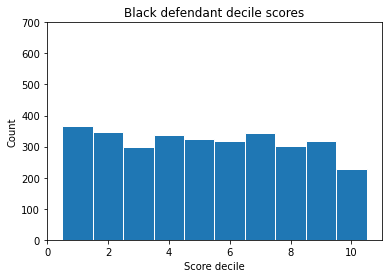

In [18]:
black_df = df_clean[df_clean['race'] == 'African-American']
black_df['decile_score'].hist(edgecolor='white', bins=np.arange(13)-0.5,grid=False)
plt.ylim([0,700])
plt.xlim([0,11])
plt.title('Black defendant decile scores')
plt.xlabel('Score decile')
plt.ylabel('Count')

Text(0.5, 0, 'Score decile')

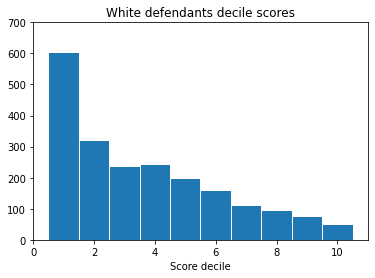

In [19]:
black_df = df_clean[df_clean['race'] == 'Caucasian']
black_df['decile_score'].hist(edgecolor='white', bins=np.arange(13)-0.5,grid=False)
plt.ylim([0,700])
plt.xlim([0,11])
plt.title('White defendants decile scores')
plt.xlabel('Score decile')

In [20]:
pd.crosstab(df_clean.decile_score, df_clean.race)

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
decile_score,,,,,,
1,365,15,605,159,0,142
2,346,4,321,89,2,60
3,298,5,238,73,1,32
4,337,0,243,47,0,39
5,323,1,200,39,0,19
6,318,2,160,27,2,20
7,343,1,113,28,2,9
8,301,2,96,14,0,7
9,317,0,77,17,2,7


After filtering out bad rows, our first question is whether there is a significant difference in Compas scores between races. To do so we need to change some variables into factors, and run a logistic regression, comparing low scores to high scores.

In [21]:
lr = LogisticRegression(solver='lbfgs')

In [22]:
df_crime = pd.get_dummies(df_clean['c_charge_degree'],prefix='crimefactor',drop_first=True)
df_age = pd.get_dummies(df_clean['age_cat'],prefix='age')
df_race = pd.get_dummies(df_clean['race'],prefix='race')
df_gender = pd.get_dummies(df_clean['sex'],prefix='sex',drop_first=True)
df_score = pd.get_dummies(df_clean['score_text'] != 'Low',prefix='score_factor',drop_first=True)

In [23]:
df_lr = pd.concat([df_crime, df_age,df_race,df_gender,
                   df_clean['priors_count'],df_clean['two_year_recid']
                  ],axis=1)

In [24]:
lr.fit(df_lr,df_score.values.ravel())

LogisticRegression()

In [25]:
cols = np.concatenate([df_crime.columns.values, 
                df_age.columns.values,
                df_race.columns.values,
                df_gender.columns.values,
                ['priors_count'],
                ['two_year_recid']
               ])

In [32]:
assert len(cols) == len(lr.coef_[0])
print('%.3f' % lr.intercept_, '(Intercept)') 
for i,j in zip(cols, lr.coef_[0]): print('%.3f' % j, i)

-1.335 (Intercept)
-0.310 crimefactor_M
0.018 age_25 - 45
-1.328 age_Greater than 45
1.319 age_Less than 25
0.490 race_African-American
-0.201 race_Asian
0.013 race_Caucasian
-0.409 race_Hispanic
0.909 race_Native American
-0.793 race_Other
-0.219 sex_Male
0.268 priors_count
0.683 two_year_recid


Correcting for the seriousness of their crime, previous arrests, and future criminal behavior, these results show that Black defendants are 44% more likely to receive a higher COMPAS score than white defendants.

In [33]:
control = np.exp(-1.335) / (1 + np.exp(-1.335))
black_odds = np.exp(0.490) / (1 - control + (control * np.exp(0.490)))
print('Black defendants: %.4f' % black_odds)

Black defendants: 1.4423


In [35]:
import statsmodels.api as sm
from statsmodels.formula.api import logit
catCols = ['score_text','age_cat','sex','race','c_charge_degree']
df_clean.loc[:,catCols] = df_clean.loc[:,catCols].astype('category')

# dfDummies = pd.get_dummies(data = dfFiltered.loc[dfFiltered['score_text'] != 'Low',:], columns=catCols)
dfDummies = pd.get_dummies(data = df_clean, columns=catCols)

# Clean column names
new_column_names = [col.lstrip().rstrip().lower().replace(" ", "_").replace("-", "_") for col in dfDummies.columns]
dfDummies.columns = new_column_names

# We want another variable that combines Medium and High
dfDummies['score_text_medhi'] = dfDummies['score_text_medium'] + dfDummies['score_text_high']


In [36]:
# R-style specification
formula = 'score_text_medhi ~ sex_female + age_cat_greater_than_45 + age_cat_less_than_25 + race_african_american + race_asian + race_hispanic + race_native_american + race_other + priors_count + c_charge_degree_m + two_year_recid'

score_mod = logit(formula, data = dfDummies).fit()
print(score_mod.summary())

Optimization terminated successfully.
         Current function value: 0.499708
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:       score_text_medhi   No. Observations:                 6172
Model:                          Logit   Df Residuals:                     6160
Method:                           MLE   Df Model:                           11
Date:                Tue, 09 Nov 2021   Pseudo R-squ.:                  0.2729
Time:                        19:11:02   Log-Likelihood:                -3084.2
converged:                       True   LL-Null:                       -4241.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.5255      0.079    -19.430      0.000      -1.679   

Female defendants are 19.4% more likely to receive a higher score than male defendants

In [38]:
np.exp(0.2213) / (1 - control + (control * np.exp(0.2213)))

1.1948243807769987